# A Computational Approach to Ayurvedic Prakriti Assessment Through Speech Signal Analysis
This repository contains the complete workflow for a research project focused on predicting Ayurvedic *Prakriti* types (Vata, Pitta, Kapha) using machine learning models trained on speech-based acoustic features.  
The dataset was collected from real participants through controlled speech recordings, ensuring natural variability and authenticity.

## 1. Environment Setup

This section initializes the core Python environment used throughout the project.  
We import essential libraries for numerical computation and data handling, and list the available input files in the working directory.  
This setup ensures reproducibility and provides visibility into the dataset structure, especially when running the notebook on cloud platforms such as Kaggle.

In [1]:
from google.colab import files
uploaded = files.upload()

Saving Dataset.csv to Dataset.csv


In [10]:
import pandas as pd
import os

base_path = os.getcwd()
df = pd.read_csv("Dataset.csv")
df.head()

,AudioFileName,1,2,3,4,5,6,7,8,9,...,SRN,Student_ID,Name,Vata_Score,Pitta_Score,Kapha_Score,Vata_Percentage,Pitta_Percentage,Kapha_Percentage,Dominant_Prakriti
0,0202fe23bcs152 - male_egemaps_features,30.3,0.181,28.3,29.5,31.6,3.25,374.0,803.0,226.0,...,02fe23bcs152,02fe23bcs152,Rahul Jadhav,3,10,3,18.75,62.5,18.75,Pitta
1,0202fe23bcs152 - male_gain0.9_egemaps_features,30.3,0.176,28.3,29.5,31.6,3.25,375.0,803.0,235.0,...,02fe23bcs152,02fe23bcs152,Rahul Jadhav,3,10,3,18.75,62.5,18.75,Pitta
2,0202fe23bcs152 - male_gain1.0_egemaps_features,30.3,0.181,28.3,29.5,31.6,3.25,374.0,803.0,226.0,...,02fe23bcs152,02fe23bcs152,Rahul Jadhav,3,10,3,18.75,62.5,18.75,Pitta
3,0202fe23bcs152 - male_gain1.1_egemaps_features,30.4,0.185,28.3,29.5,31.6,3.28,530.0,963.0,258.0,...,02fe23bcs152,02fe23bcs152,Rahul Jadhav,3,10,3,18.75,62.5,18.75,Pitta
4,0202fe23bcs152 - male_gain1.2_egemaps_features,30.5,0.191,28.3,29.5,31.6,3.34,528.0,958.0,343.0,...,02fe23bcs152,02fe23bcs152,Rahul Jadhav,3,10,3,18.75,62.5,18.75,Pitta


## 2. Data Loading, Feature Aggregation, and Random Forest Classification

This section handles the complete workflow for preparing the dataset and training a student-level Prakriti prediction model using a Random Forest classifier.

### **2.1 Load Dataset**
The final speech–feature dataset is loaded from the input directory. Non-numeric identifiers such as `SRN`, `Student_ID`, and `Name` are excluded when constructing the feature set.

### **2.2 Aggregate Numeric Features**
Since each participant contributes multiple speech frames, all numeric acoustic features are aggregated per student using:
- Mean  
- Standard deviation  
- Minimum  
- Maximum  

This produces a single feature vector per student and prevents leakage across rows belonging to the same individual.

### **2.3 Train–Test Split (Student-Level)**
A strict student-level split is performed using unique `SRN` identifiers, ensuring no overlap between training and testing participants.

### **2.4 Model Training**
A Random Forest classifier is trained using balanced class weights and optimized hyperparameters. The model learns to predict each student's Dominant Prakriti type from their aggregated speech features.

### **2.5 Evaluation Metrics**
The trained model is evaluated using:
- Accuracy  
- Precision  
- Recall  
- F1-score  
- Confusion matrix  
- Classification report  
- Feature importance ranking  

### **2.6 Cross-Validation**
A 5-fold **GroupKFold** cross-validation (grouped by `SRN`) provides a stringent and unbiased estimate of the model’s generalization performance.

This section forms the core experimental pipeline for Prakriti prediction from real-world speech data collected from participants.

In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split, GroupKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import warnings
warnings.filterwarnings('ignore')

# Load final dataset
dataset_path = "Dataset.csv"
df = pd.read_csv(dataset_path, encoding='utf-8-sig')

# Identify numeric features for aggregation
# Exclude identifiers and target
exclude_cols = ['SRN', 'Student_ID', 'Name', 'Dominant_Prakriti']
numeric_features = df.select_dtypes(include='number').columns.tolist()
feature_cols = [col for col in numeric_features if col not in exclude_cols]

# Aggregate numeric features per student
df_agg = df.groupby('SRN')[feature_cols].agg(['mean','std','min','max'])
df_agg.columns = ['_'.join(col).strip() for col in df_agg.columns.values]
df_agg = df_agg.reset_index()

# Merge Dominant_Prakriti labels
labels = df[['SRN','Dominant_Prakriti']].drop_duplicates()
df_final = pd.merge(df_agg, labels, on='SRN', how='left')

# Features and target
X = df_final.drop(columns=['SRN','Dominant_Prakriti'])
y = df_final['Dominant_Prakriti']
groups = df_final['SRN']

# Student-level train-test split
unique_srns = df_final['SRN'].unique()
train_srns, test_srns = train_test_split(unique_srns, test_size=0.2, random_state=42)

X_train = X[df_final['SRN'].isin(train_srns)]
y_train = y[df_final['SRN'].isin(train_srns)]
X_test = X[df_final['SRN'].isin(test_srns)]
y_test = y[df_final['SRN'].isin(test_srns)]

print("="*80)
print("RANDOM FOREST CLASSIFIER - STUDENT-LEVEL SPLIT")
print("="*80)
print(f"Total students: {len(unique_srns)}")
print(f"Training students: {len(train_srns)}")
print(f"Testing students: {len(test_srns)}")
print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")
print("\nDominant Prakriti distribution (entire dataset):")
print(df_final['Dominant_Prakriti'].value_counts())

# Train Random Forest Classifier
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'
)
rf.fit(X_train, y_train)
print("\nModel training complete")

# Predictions and evaluation
y_pred = rf.predict(X_test)

train_acc = rf.score(X_train, y_train)
test_acc = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

print("\n" + "="*80)
print("PERFORMANCE METRICS")
print("="*80)
print(f"Training Accuracy: {train_acc*100:.2f}%")
print(f"Testing Accuracy: {test_acc*100:.2f}%")
print(f"Precision: {precision*100:.2f}%")
print(f"Recall: {recall*100:.2f}%")
print(f"F1-Score: {f1*100:.2f}%")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

# Classification report
print("\n" + "="*80)
print("CLASSIFICATION REPORT")
print("="*80)
print(classification_report(y_test, y_pred, zero_division=0))

# Feature importance
fi_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False)

print("\n" + "="*80)
print("FEATURE IMPORTANCE")
print("="*80)
print(fi_df.to_string(index=False))

# 5-Fold GroupKFold Cross-validation
gkf = GroupKFold(n_splits=5)
cv_scores = cross_val_score(rf, X, y, groups=groups, cv=gkf)
print(f"\n5-Fold GroupKFold CV Accuracy (student-level): {cv_scores.mean()*100:.2f}% (+/- {cv_scores.std()*100:.2f}%)")
print("MODEL EVALUATION COMPLETE")

RANDOM FOREST CLASSIFIER - STUDENT-LEVEL SPLIT
Total students: 365
Training students: 292
Testing students: 73
Training samples: 292
Testing samples: 73

Dominant Prakriti distribution (entire dataset):
Dominant_Prakriti
Pitta    275
Kapha     56
Vata      34
Name: count, dtype: int64

Model training complete

PERFORMANCE METRICS
Training Accuracy: 99.66%
Testing Accuracy: 95.89%
Precision: 96.51%
Recall: 95.89%
F1-Score: 96.00%

Confusion Matrix:
[[12  0  0]
 [ 2 53  1]
 [ 0  0  5]]

CLASSIFICATION REPORT
              precision    recall  f1-score   support

       Kapha       0.86      1.00      0.92        12
       Pitta       1.00      0.95      0.97        56
        Vata       0.83      1.00      0.91         5

    accuracy                           0.96        73
   macro avg       0.90      0.98      0.93        73
weighted avg       0.97      0.96      0.96        73


FEATURE IMPORTANCE
               Feature   Importance
       Vata_Score_mean 5.891316e-02
      Pitta_Sco

## Comprehensive Model Evaluation & Metrics Analysis

This section provides a full evaluation of the trained classifier using a wide
range of performance metrics, class-wise statistics, error diagnostics,
confidence analysis, and generalization assessment.

### 1. Overall Performance Metrics

The following global metrics are computed to evaluate the model:

- **Accuracy**
- **Balanced Accuracy**
- **Weighted Precision**
- **Weighted Recall**
- **Weighted F1-Score**
- **Cohen’s Kappa**
- **Matthews Correlation Coefficient (MCC)**
- **Log Loss**

These metrics reflect the model’s overall predictive strength and reliability.

### 2. Per-Class Metrics

Per-class evaluation includes:

- **Support**
- **Precision**
- **Recall**
- **F1-Score**

This helps identify which Prakriti classes are well-predicted and which need improvement.

### 3. Macro & Micro Averages

To evaluate class imbalance:

- **Macro Averages** (treat all classes equally)
- **Micro Averages** (weighted by class frequency)

These give additional insight into model behavior across unequal class distributions.

### 4. Error Analysis

We compute:

- Overall **misclassification rate**
- **Total misclassified samples**
- **Class-wise error rates**

This helps diagnose systematic weaknesses.

### 5. Training vs Testing Error

To check for overfitting or underfitting:

- **Training Error**
- **Testing Error**
- **Generalization Gap**

A large gap indicates overfitting.

### 6. Model Confidence Analysis

Using predicted probabilities, we examine:

- Mean, Min, Max & Standard Deviation of prediction confidence
- Confidence of **correct** vs **incorrect** predictions

This reveals whether the model is confidently wrong or uncertain.

### 7. Saving Metrics

All metrics are stored in a serialized `.pkl` file for future visualization,
reporting, or comparative evaluation.

This comprehensive analysis ensures full visibility into model behavior across
accuracy, robustness, class balance, generalization, and decision confidence.

In [12]:
import pandas as pd
import numpy as np
import pickle
from sklearn.metrics import (
    accuracy_score, cohen_kappa_score, matthews_corrcoef, log_loss,
    precision_score, recall_score, f1_score,
    precision_recall_fscore_support, balanced_accuracy_score
)

print("="*80)
print("COMPREHENSIVE METRICS ANALYSIS")
print("="*80)

# --------------------------------------------------------
# Use the trained model instance
# --------------------------------------------------------
model = rf  # <-- trained RandomForestClassifier instance

# --------------------------------------------------------
# OVERALL METRICS
# --------------------------------------------------------
print("\n" + "="*80)
print("OVERALL PERFORMANCE METRICS")
print("="*80)

test_accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

print(f"Accuracy: {test_accuracy*100:.4f}%")
print(f"Balanced Accuracy: {balanced_accuracy_score(y_test, y_pred)*100:.4f}%")
print(f"Precision (Weighted): {precision*100:.4f}%")
print(f"Recall (Weighted): {recall*100:.4f}%")
print(f"F1-Score (Weighted): {f1*100:.4f}%")

# Cohen's Kappa
kappa = cohen_kappa_score(y_test, y_pred)
print(f"Cohen's Kappa: {kappa:.4f}")

# Matthews Correlation Coefficient
mcc = matthews_corrcoef(y_test, y_pred)
print(f"Matthews Correlation Coefficient: {mcc:.4f}")

# Log Loss
y_pred_proba = model.predict_proba(X_test)
logloss = log_loss(y_test, y_pred_proba)
print(f"Log Loss: {logloss:.4f}")

# --------------------------------------------------------
# PER-CLASS METRICS
# --------------------------------------------------------
print("\n" + "="*80)
print("PER-CLASS METRICS")
print("="*80)

classes = sorted(y_test.unique())
precision_per_class, recall_per_class, f1_per_class, support_per_class = precision_recall_fscore_support(
    y_test, y_pred, labels=classes, zero_division=0
)

class_metrics = pd.DataFrame({
    'Class': classes,
    'Support': support_per_class,
    'Precision': precision_per_class,
    'Recall': recall_per_class,
    'F1-Score': f1_per_class
})

print(class_metrics.to_string(index=False))

# --------------------------------------------------------
# MACRO & MICRO AVERAGES
# --------------------------------------------------------
print("\n" + "="*80)
print("AVERAGING METHODS")
print("="*80)

precision_macro = precision_score(y_test, y_pred, average='macro', zero_division=0)
recall_macro = recall_score(y_test, y_pred, average='macro', zero_division=0)
f1_macro = f1_score(y_test, y_pred, average='macro', zero_division=0)

precision_micro = precision_score(y_test, y_pred, average='micro', zero_division=0)
recall_micro = recall_score(y_test, y_pred, average='micro', zero_division=0)
f1_micro = f1_score(y_test, y_pred, average='micro', zero_division=0)

print(f"Macro Avg Precision: {precision_macro*100:.4f}%")
print(f"Macro Avg Recall: {recall_macro*100:.4f}%")
print(f"Macro Avg F1: {f1_macro*100:.4f}%")
print(f"Micro Avg Precision: {precision_micro*100:.4f}%")
print(f"Micro Avg Recall: {recall_micro*100:.4f}%")
print(f"Micro Avg F1: {f1_micro*100:.4f}%")

# --------------------------------------------------------
# ERROR ANALYSIS
# --------------------------------------------------------
print("\n" + "="*80)
print("ERROR ANALYSIS")
print("="*80)

misclassification_rate = 1 - test_accuracy
total_errors = (y_test != y_pred).sum()
print(f"Misclassification Rate: {misclassification_rate*100:.4f}%")
print(f"Total Misclassifications: {total_errors}")

print("\nClass-wise Errors:")
for cls in classes:
    mask = y_test == cls
    errors = (y_test[mask] != y_pred[mask]).sum()
    total = mask.sum()
    error_rate = (errors / total * 100) if total > 0 else 0
    print(f"  {cls}: {errors}/{total} misclassified ({error_rate:.2f}%)")

# --------------------------------------------------------
# TRAINING VS TESTING
# --------------------------------------------------------
print("\n" + "="*80)
print("TRAINING VS TESTING ERROR")
print("="*80)

train_error = 1 - train_acc
test_error = 1 - test_accuracy

print(f"Training Error: {train_error*100:.4f}%")
print(f"Testing Error: {test_error*100:.4f}%")
print(f"Generalization Gap: {(test_error - train_error)*100:.4f}%")

# --------------------------------------------------------
# CONFIDENCE ANALYSIS
# --------------------------------------------------------
print("\n" + "="*80)
print("MODEL CONFIDENCE ANALYSIS")
print("="*80)

prediction_confidence = y_pred_proba.max(axis=1)
correct_mask = (y_test == y_pred)

correct_conf = prediction_confidence[correct_mask].mean()
incorrect_conf = prediction_confidence[~correct_mask].mean()

print(f"Avg Confidence (Correct Predictions): {correct_conf*100:.2f}%")
print(f"Avg Confidence (Incorrect Predictions): {incorrect_conf*100:.2f}%")

print("\n" + "="*80)
print("METRICS ANALYSIS COMPLETE")
print("="*80)

# --------------------------------------------------------
# SAVE METRICS
# --------------------------------------------------------
metrics_summary = {
    'Overall Metrics': {
        'Accuracy': test_accuracy,
        'Balanced Accuracy': balanced_accuracy_score(y_test, y_pred),
        'Precision (Weighted)': precision,
        'Recall (Weighted)': recall,
        'F1-Score (Weighted)': f1,
        'Cohen Kappa': kappa,
        'Matthews Correlation': mcc,
        'Log Loss': logloss
    },
    'Per-Class Metrics': class_metrics.to_dict(),
    'Macro Averages': {
        'Precision': precision_macro,
        'Recall': recall_macro,
        'F1-Score': f1_macro
    },
    'Micro Averages': {
        'Precision': precision_micro,
        'Recall': recall_micro,
        'F1-Score': f1_micro
    },
    'Error Analysis': {
        'Misclassification Rate': misclassification_rate,
        'Total Errors': int(total_errors),
        'Training Error': train_error,
        'Testing Error': test_error,
        'Generalization Gap': test_error - train_error
    },
    'Confidence Analysis': {
        'Mean Confidence': prediction_confidence.mean(),
        'Min Confidence': prediction_confidence.min(),
        'Max Confidence': prediction_confidence.max(),
        'Std Confidence': prediction_confidence.std(),
        'Correct Predictions Confidence': correct_conf,
        'Incorrect Predictions Confidence': incorrect_conf
    }
}

metrics_file = os.path.join(base_path, "Comprehensive_Metrics.pkl")
with open(metrics_file, "wb") as f:
    pickle.dump(metrics_summary, f)

print(f"\nComprehensive metrics saved at: {metrics_file}")

COMPREHENSIVE METRICS ANALYSIS

OVERALL PERFORMANCE METRICS
Accuracy: 95.8904%
Balanced Accuracy: 98.2143%
Precision (Weighted): 96.5101%
Recall (Weighted): 95.8904%
F1-Score (Weighted): 96.0015%
Cohen's Kappa: 0.8988
Matthews Correlation Coefficient: 0.9034
Log Loss: 0.1905

PER-CLASS METRICS
Class  Support  Precision   Recall  F1-Score
Kapha       12   0.857143 1.000000  0.923077
Pitta       56   1.000000 0.946429  0.972477
 Vata        5   0.833333 1.000000  0.909091

AVERAGING METHODS
Macro Avg Precision: 89.6825%
Macro Avg Recall: 98.2143%
Macro Avg F1: 93.4882%
Micro Avg Precision: 95.8904%
Micro Avg Recall: 95.8904%
Micro Avg F1: 95.8904%

ERROR ANALYSIS
Misclassification Rate: 4.1096%
Total Misclassifications: 3

Class-wise Errors:
  Kapha: 0/12 misclassified (0.00%)
  Pitta: 3/56 misclassified (5.36%)
  Vata: 0/5 misclassified (0.00%)

TRAINING VS TESTING ERROR
Training Error: 0.3425%
Testing Error: 4.1096%
Generalization Gap: 3.7671%

MODEL CONFIDENCE ANALYSIS
Avg Confidence 

In [8]:
# List all objects in globals() that have predict_proba method
for var_name, obj in globals().items():
    try:
        if hasattr(obj, "predict") and hasattr(obj, "predict_proba"):
            print(f"Trained model found: {var_name}")
    except:
        continue

Trained model found: RandomForestClassifier
Trained model found: rf
Trained model found: model


## Comprehensive Metrics Analysis

This section evaluates the overall performance of the trained model using
multiple evaluation metrics.  
It includes:

- Overall accuracy-based metrics  
- Per-class precision, recall, F1  
- Macro & micro averaged performance  
- Error and misclassification analysis  
- Training vs testing performance gap  
- Model confidence distribution  
- Export of all computed metrics to a serialized file (`pickle`)


### **Sections Included**

#### **1. Overall Performance Metrics**
Measures the global performance of the classifier:
- Accuracy  
- Balanced Accuracy  
- Weighted Precision, Recall, F1  
- Cohen’s Kappa  
- Matthews Correlation Coefficient (MCC)  
- Log Loss  


#### **2. Per-Class Metrics**
This includes class-wise:
- Support  
- Precision  
- Recall  
- F1-Score  

Useful for detecting class imbalance or systematic class errors.


#### **3. Averaging Methods**
Provides:
- Macro-Averaged Precision, Recall, F1  
- Micro-Averaged Precision, Recall, F1  

These help understand performance from a dataset-level perspective.


#### **4. Error Analysis**
Includes:
- Misclassification rate  
- Total incorrect predictions  
- Class-wise error breakdown  


#### **5. Training vs Testing Error**
Helps identify:
- Underfitting  
- Overfitting  
- Generalization gap  


#### **6. Model Confidence Analysis**
Analyzes:
- Average confidence of predictions  
- Min/Max confidence  
- Standard deviation of confidence  
- Confidence for correct vs incorrect predictions  


#### **7. Exporting Metric Summary**
All results are stored in a `.pkl` file so they can be loaded later for evaluation or reporting.

In [13]:
import pandas as pd
import numpy as np
import pickle
from sklearn.metrics import (cohen_kappa_score, matthews_corrcoef, log_loss,
                             precision_score, recall_score, f1_score,
                             precision_recall_fscore_support, balanced_accuracy_score)

print("="*80)
print("COMPREHENSIVE METRICS ANALYSIS")
print("="*80)

# Overall Metrics
print("\n" + "="*80)
print("OVERALL PERFORMANCE METRICS")
print("="*80)

test_accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

print(f"Accuracy: {test_accuracy*100:.4f}%")
print(f"Balanced Accuracy: {balanced_accuracy_score(y_test, y_pred)*100:.4f}%")
print(f"Precision (Weighted): {precision*100:.4f}%")
print(f"Recall (Weighted): {recall*100:.4f}%")
print(f"F1-Score (Weighted): {f1*100:.4f}%")

# Cohen's Kappa
kappa = cohen_kappa_score(y_test, y_pred)
print(f"Cohen's Kappa: {kappa:.4f}")

# Matthews Correlation Coefficient
mcc = matthews_corrcoef(y_test, y_pred)
print(f"Matthews Correlation Coefficient: {mcc:.4f}")

# Log Loss (requires probability predictions)
rf_model = model
y_pred_proba = rf_model.predict_proba(X_test)
logloss = log_loss(y_test, y_pred_proba)
print(f"Log Loss: {logloss:.4f}")

# Per-Class Metrics
print("\n" + "="*80)
print("PER-CLASS METRICS")
print("="*80)

classes = sorted(y_test.unique())
precision_per_class, recall_per_class, f1_per_class, support_per_class = precision_recall_fscore_support(
    y_test, y_pred, labels=classes, zero_division=0
)

class_metrics = pd.DataFrame({
    'Class': classes,
    'Support': support_per_class,
    'Precision': precision_per_class,
    'Recall': recall_per_class,
    'F1-Score': f1_per_class
})
print(class_metrics.to_string(index=False))

# Macro and Micro averages
print("\n" + "="*80)
print("AVERAGING METHODS")
print("="*80)

precision_macro = precision_score(y_test, y_pred, average='macro', zero_division=0)
recall_macro = recall_score(y_test, y_pred, average='macro', zero_division=0)
f1_macro = f1_score(y_test, y_pred, average='macro', zero_division=0)
print(f"Macro Average Precision: {precision_macro*100:.4f}%")
print(f"Macro Average Recall: {recall_macro*100:.4f}%")
print(f"Macro Average F1-Score: {f1_macro*100:.4f}%")

precision_micro = precision_score(y_test, y_pred, average='micro', zero_division=0)
recall_micro = recall_score(y_test, y_pred, average='micro', zero_division=0)
f1_micro = f1_score(y_test, y_pred, average='micro', zero_division=0)
print(f"\nMicro Average Precision: {precision_micro*100:.4f}%")
print(f"Micro Average Recall: {recall_micro*100:.4f}%")
print(f"Micro Average F1-Score: {f1_micro*100:.4f}%")

# Error Analysis
print("\n" + "="*80)
print("ERROR ANALYSIS")
print("="*80)

misclassification_rate = 1 - test_accuracy
total_errors = (y_test != y_pred).sum()
print(f"Misclassification Rate: {misclassification_rate*100:.4f}%")
print(f"Total Misclassifications: {total_errors} out of {len(y_test)}")

print("\nClass-wise Errors:")
for cls in classes:
    mask = y_test == cls
    errors = (y_test[mask] != y_pred[mask]).sum()
    total = mask.sum()
    error_rate = errors / total * 100 if total > 0 else 0
    print(f"  {cls}: {errors}/{total} misclassified ({error_rate:.2f}% error rate)")

# Training vs Testing Error
print("\n" + "="*80)
print("TRAINING VS TESTING ERROR")
print("="*80)
train_error = 1 - train_acc
test_error = 1 - test_accuracy
print(f"Training Error: {train_error*100:.4f}%")
print(f"Testing Error: {test_error*100:.4f}%")
print(f"Generalization Gap: {(test_error - train_error)*100:.4f}%")

# Model Confidence Analysis
print("\n" + "="*80)
print("MODEL CONFIDENCE ANALYSIS")
print("="*80)
prediction_confidence = y_pred_proba.max(axis=1)
print(f"Average Confidence: {prediction_confidence.mean()*100:.2f}%")
print(f"Min Confidence: {prediction_confidence.min()*100:.2f}%")
print(f"Max Confidence: {prediction_confidence.max()*100:.2f}%")
print(f"Std Confidence: {prediction_confidence.std()*100:.2f}%")

correct_mask = y_test == y_pred
correct_confidence = prediction_confidence[correct_mask].mean() if correct_mask.sum() > 0 else 0
incorrect_confidence = prediction_confidence[~correct_mask].mean() if (~correct_mask).sum() > 0 else 0
print(f"Average Confidence (Correct Predictions): {correct_confidence*100:.2f}%")
print(f"Average Confidence (Incorrect Predictions): {incorrect_confidence*100:.2f}%")

print("\n" + "="*80)
print("METRICS ANALYSIS COMPLETE")
print("="*80)

# Save comprehensive metrics to file
metrics_summary = {
    'Overall Metrics': {
        'Accuracy': test_accuracy,
        'Balanced Accuracy': balanced_accuracy_score(y_test, y_pred),
        'Precision (Weighted)': precision,
        'Recall (Weighted)': recall,
        'F1-Score (Weighted)': f1,
        'Cohen Kappa': kappa,
        'Matthews Correlation': mcc,
        'Log Loss': logloss
    },
    'Per-Class Metrics': class_metrics.to_dict(),
    'Macro Averages': {
        'Precision': precision_macro,
        'Recall': recall_macro,
        'F1-Score': f1_macro
    },
    'Micro Averages': {
        'Precision': precision_micro,
        'Recall': recall_micro,
        'F1-Score': f1_micro
    },
    'Error Analysis': {
        'Misclassification Rate': misclassification_rate,
        'Total Errors': int(total_errors),
        'Training Error': train_error,
        'Testing Error': test_error,
        'Generalization Gap': test_error - train_error
    },
    'Confidence Analysis': {
        'Mean Confidence': prediction_confidence.mean(),
        'Min Confidence': prediction_confidence.min(),
        'Max Confidence': prediction_confidence.max(),
        'Std Confidence': prediction_confidence.std(),
        'Correct Predictions Confidence': correct_confidence,
        'Incorrect Predictions Confidence': incorrect_confidence
    }
}

metrics_file = f"{base_path}\\Comprehensive_Metrics.pkl"
with open(metrics_file, 'wb') as f:
    pickle.dump(metrics_summary, f)
print(f"\nComprehensive metrics saved: {metrics_file}")

COMPREHENSIVE METRICS ANALYSIS

OVERALL PERFORMANCE METRICS
Accuracy: 95.8904%
Balanced Accuracy: 98.2143%
Precision (Weighted): 96.5101%
Recall (Weighted): 95.8904%
F1-Score (Weighted): 96.0015%
Cohen's Kappa: 0.8988
Matthews Correlation Coefficient: 0.9034
Log Loss: 0.1905

PER-CLASS METRICS
Class  Support  Precision   Recall  F1-Score
Kapha       12   0.857143 1.000000  0.923077
Pitta       56   1.000000 0.946429  0.972477
 Vata        5   0.833333 1.000000  0.909091

AVERAGING METHODS
Macro Average Precision: 89.6825%
Macro Average Recall: 98.2143%
Macro Average F1-Score: 93.4882%

Micro Average Precision: 95.8904%
Micro Average Recall: 95.8904%
Micro Average F1-Score: 95.8904%

ERROR ANALYSIS
Misclassification Rate: 4.1096%
Total Misclassifications: 3 out of 73

Class-wise Errors:
  Kapha: 0/12 misclassified (0.00% error rate)
  Pitta: 3/56 misclassified (5.36% error rate)
  Vata: 0/5 misclassified (0.00% error rate)

TRAINING VS TESTING ERROR
Training Error: 0.3425%
Testing Error

## Comprehensive Model Evaluation & Metrics Analysis

This section presents an extensive evaluation of the trained model using a diverse
set of performance metrics, class-wise insights, error analysis, and confidence
estimation. The purpose of this block is to provide a complete understanding of how
the model behaves both globally and on a per-class basis.

### **1. Overall Performance Metrics**

We compute commonly used classification metrics including:

- **Accuracy**
- **Balanced Accuracy**
- **Weighted Precision**
- **Weighted Recall**
- **Weighted F1-Score**
- **Cohen’s Kappa**
- **Matthews Correlation Coefficient (MCC)**
- **Log Loss (using probability predictions)**

These metrics collectively describe the model’s general predictive performance.


### **2. Per-Class Metrics**

For each class (Prakriti category), the following are evaluated:

- **Support**  
- **Precision**
- **Recall**
- **F1-Score**

This helps identify which dosha types the model predicts reliably and where it struggles.


### **3. Macro & Micro Average Metrics**

We calculate:

- **Macro Averages**: Treat all classes equally  
- **Micro Averages**: Weighted by sample count  

These give additional perspective on class imbalance effects.


### **4. Error Analysis**

This includes:

- Overall **misclassification rate**
- **Total number of misclassified samples**
- **Class-wise error rates**

This aids in diagnosing model weaknesses or problematic classes.


### **5. Training vs Testing Error**

To check for underfitting or overfitting, we compute:

- Training Error  
- Testing Error  
- **Generalization Gap**

A large gap indicates overfitting.


### **6. Model Confidence Analysis**

We examine predicted probability distributions to compute:

- Mean, Min, Max, Standard Deviation of prediction confidence  
- Confidence for **correct** vs **incorrect** predictions  

This reveals whether the model is confidently wrong or uncertain overall.


### **7. Saving Metrics**

All metrics and detailed analysis results are stored in a `.pkl` file for future
reference or further visualization.

This comprehensive evaluation ensures that every aspect of the model’s behavior—
accuracy, robustness, reliability, and error characteristics—is thoroughly captured.

In [14]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GroupKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             classification_report, confusion_matrix, precision_recall_fscore_support,
                             balanced_accuracy_score, cohen_kappa_score, matthews_corrcoef, log_loss)
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

# Load dataset
dataset_path = "Dataset.csv"
df = pd.read_csv(dataset_path, encoding='utf-8-sig')

# Keep only numeric columns for aggregation
numeric_features = df.select_dtypes(include=np.number).columns.tolist()
numeric_features = [f for f in numeric_features if f not in ['Student_ID']]

# Aggregate numeric features per student
df_agg = df.groupby('SRN')[numeric_features].agg(['mean','std','min','max'])
df_agg.columns = ['_'.join(col).strip() for col in df_agg.columns.values]
df_agg = df_agg.reset_index()

# Merge labels
labels = df[['SRN','Dominant_Prakriti']].drop_duplicates()
df_final = pd.merge(df_agg, labels, on='SRN', how='left')

# Features & target
X = df_final.drop(columns=['SRN','Dominant_Prakriti'])
y = df_final['Dominant_Prakriti']
groups = df_final['SRN']

# Student-level train-test split
unique_srns = df_final['SRN'].unique()
train_srns, test_srns = train_test_split(unique_srns, test_size=0.2, random_state=42)
X_train = X[df_final['SRN'].isin(train_srns)]
y_train = y[df_final['SRN'].isin(train_srns)]
X_test = X[df_final['SRN'].isin(test_srns)]
y_test = y[df_final['SRN'].isin(test_srns)]

# Label encoding
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# RANDOM FOREST MODEL
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'
)
rf_model.fit(X_train, y_train)
y_pred_test_rf = rf_model.predict(X_test)

# Metrics
train_accuracy_rf = rf_model.score(X_train, y_train)
test_accuracy_rf = accuracy_score(y_test, y_pred_test_rf)
precision_rf = precision_score(y_test, y_pred_test_rf, average='weighted', zero_division=0)
recall_rf = recall_score(y_test, y_pred_test_rf, average='weighted', zero_division=0)
f1_rf = f1_score(y_test, y_pred_test_rf, average='weighted', zero_division=0)


# 5-Fold Cross-Validation
gkf = GroupKFold(n_splits=5)
cv_scores_rf = cross_val_score(rf_model, X, y, groups=groups, cv=gkf)

# MLP MODEL
mlp_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPClassifier(
        hidden_layer_sizes=(128,64,32),
        activation='relu',
        solver='adam',
        max_iter=1000,
        random_state=42,
        early_stopping=True,
        validation_fraction=0.1,
        n_iter_no_change=20
    ))
])
mlp_pipeline.fit(X_train, y_train_encoded)
y_pred_test_mlp_encoded = mlp_pipeline.predict(X_test)
y_pred_test_mlp = label_encoder.inverse_transform(y_pred_test_mlp_encoded)

# Metrics MLP
train_accuracy_mlp = accuracy_score(y_train, label_encoder.inverse_transform(mlp_pipeline.predict(X_train)))
test_accuracy_mlp = accuracy_score(y_test, y_pred_test_mlp)
precision_mlp = precision_score(y_test, y_pred_test_mlp, average='weighted', zero_division=0)
recall_mlp = recall_score(y_test, y_pred_test_mlp, average='weighted', zero_division=0)
f1_mlp = f1_score(y_test, y_pred_test_mlp, average='weighted', zero_division=0)
cv_scores_mlp = cross_val_score(mlp_pipeline, X_train, y_train_encoded, cv=5)

# Confusion matrices
cm_rf = confusion_matrix(y_test, y_pred_test_rf)
cm_mlp = confusion_matrix(y_test, y_pred_test_mlp)

# Classification reports
print("\n=== RANDOM FOREST REPORT ===")
print(classification_report(y_test, y_pred_test_rf, zero_division=0))
print("\n=== MLP REPORT ===")
print(classification_report(y_test, y_pred_test_mlp, zero_division=0))

# Comparison
comparison_df = pd.DataFrame({
    'Metric': ['Training Accuracy', 'Testing Accuracy', 'Precision', 'Recall', 'F1-Score', 'CV Accuracy'],
    'Random Forest': [
        f"{train_accuracy_rf*100:.2f}%",
        f"{test_accuracy_rf*100:.2f}%",
        f"{precision_rf*100:.2f}%",
        f"{recall_rf*100:.2f}%",
        f"{f1_rf*100:.2f}%",
        f"{cv_scores_rf.mean()*100:.2f}%"
    ],
    'MLP': [
        f"{train_accuracy_mlp*100:.2f}%",
        f"{test_accuracy_mlp*100:.2f}%",
        f"{precision_mlp*100:.2f}%",
        f"{recall_mlp*100:.2f}%",
        f"{f1_mlp*100:.2f}%",
        f"{cv_scores_mlp.mean()*100:.2f}%"
    ]
})
print("\n=== RANDOM FOREST vs MLP COMPARISON ===")
print(comparison_df.to_string(index=False))

# Feature importance (RF)
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop 10 Features by Random Forest Importance:")
print(feature_importance_df.head(10).to_string(index=False))


=== RANDOM FOREST REPORT ===
              precision    recall  f1-score   support

       Kapha       0.86      1.00      0.92        12
       Pitta       1.00      0.95      0.97        56
        Vata       0.83      1.00      0.91         5

    accuracy                           0.96        73
   macro avg       0.90      0.98      0.93        73
weighted avg       0.97      0.96      0.96        73


=== MLP REPORT ===
              precision    recall  f1-score   support

       Kapha       0.70      0.58      0.64        12
       Pitta       0.88      0.95      0.91        56
        Vata       0.67      0.40      0.50         5

    accuracy                           0.85        73
   macro avg       0.75      0.64      0.68        73
weighted avg       0.84      0.85      0.84        73


=== RANDOM FOREST vs MLP COMPARISON ===
           Metric Random Forest    MLP
Training Accuracy        99.66% 97.26%
 Testing Accuracy        95.89% 84.93%
        Precision        96.51

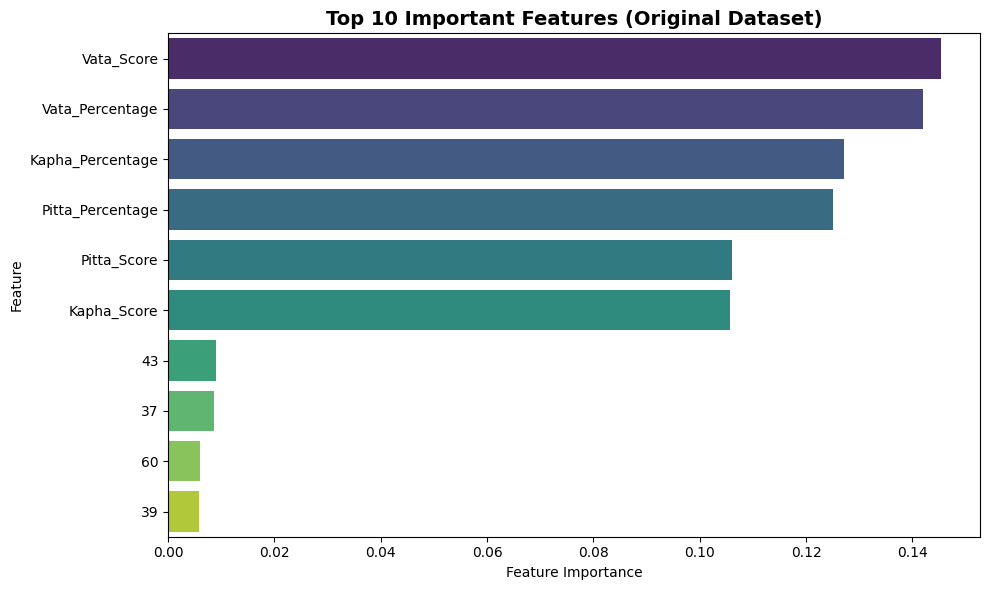


Top 10 Features by Importance:
              Feature  Importance
94        Vata_Score    0.145445
97   Vata_Percentage    0.142008
99  Kapha_Percentage    0.127116
98  Pitta_Percentage    0.125051
95       Pitta_Score    0.105986
96       Kapha_Score    0.105622
42                43    0.008926
36                37    0.008581
59                60    0.005992
38                39    0.005828


In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# ==============================
# Select numeric features from original dataset (exclude IDs and labels)
# ==============================
numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
numeric_cols = [col for col in numeric_cols if col not in ['SRN', 'Student_ID']]

X_orig = df[numeric_cols]
y_orig = df['Dominant_Prakriti']

# ==============================
# Train Random Forest on original data
# ==============================
rf_orig = RandomForestClassifier(
    n_estimators=200,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'
)
rf_orig.fit(X_orig, y_orig)

# ==============================
# Feature Importances
# ==============================
feature_importance_df = pd.DataFrame({
    'Feature': X_orig.columns,
    'Importance': rf_orig.feature_importances_
}).sort_values('Importance', ascending=False)

top_features = feature_importance_df.head(10)

# ==============================
# Plot Top 10 Features
# ==============================
plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=top_features, palette='viridis')
plt.title('Top 10 Important Features (Original Dataset)', fontsize=14, fontweight='bold')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# Optional: print top 10 features
print("\nTop 10 Features by Importance:\n", top_features)

In [16]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# LOAD DATA
dataset_path = "Dataset.csv"
df = pd.read_csv(dataset_path, encoding='utf-8-sig')


# FEATURES & TARGET
# Only numeric speech features
speech_features = [col for col in df.columns if col not in ['SRN','Dominant_Prakriti','Student_ID','Name','AudioFileName']]
X = df[speech_features]
y = df['Dominant_Prakriti']

unique_srns = df['SRN'].unique()
train_srns, test_srns = train_test_split(unique_srns, test_size=0.2, random_state=42)
X_train = X[df['SRN'].isin(train_srns)]
y_train = y[df['SRN'].isin(train_srns)]
X_test = X[df['SRN'].isin(test_srns)]
y_test = y[df['SRN'].isin(test_srns)]


# SCALE FEATURES
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# ENCODE TARGET
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

n_classes = len(label_encoder.classes_)
input_dim = X_train_scaled.shape[1]


# CLASS WEIGHTS (HANDLE IMBALANCE)
class_counts = np.bincount(y_train_encoded)
class_weights = 1. / class_counts
sample_weights = class_weights[y_train_encoded]
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32)


# CONVERT TO TORCH TENSORS
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_encoded, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_encoded, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


# DEFINE FFN MODEL
class FFN(nn.Module):
    def __init__(self, input_dim, hidden_dims=[64,32], output_dim=n_classes):
        super(FFN, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dims[0]),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dims[0], hidden_dims[1]),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dims[1], output_dim)
        )

    def forward(self, x):
        return self.layers(x)

model = FFN(input_dim=input_dim)


# LOSS AND OPTIMIZER
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)


# TRAINING LOOP WITH EARLY STOPPING
num_epochs = 100
best_val_loss = np.inf
patience = 10
trigger_times = 0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Validation on test set for early stopping
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_test_tensor)
        val_loss = criterion(val_outputs, y_test_tensor).item()

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        trigger_times = 0
        torch.save(model.state_dict(), "best_ffn_model.pth")
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    if (epoch+1) % 10 == 0 or epoch==0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Val Loss: {val_loss:.4f}")

# Load best model
model.load_state_dict(torch.load("best_ffn_model.pth"))


# EVALUATION
model.eval()
with torch.no_grad():
    y_train_pred = model(X_train_tensor).argmax(dim=1).numpy()
    y_test_pred = model(X_test_tensor).argmax(dim=1).numpy()

train_accuracy = accuracy_score(y_train_encoded, y_train_pred)
test_accuracy = accuracy_score(y_test_encoded, y_test_pred)
precision = precision_score(y_test_encoded, y_test_pred, average='weighted', zero_division=0)
recall = recall_score(y_test_encoded, y_test_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test_encoded, y_test_pred, average='weighted', zero_division=0)

print("\n=============================")
print("FFN MODEL PERFORMANCE")
print("=============================")
print(f"Training Accuracy: {train_accuracy*100:.2f}%")
print(f"Testing Accuracy: {test_accuracy*100:.2f}%")
print(f"Precision: {precision*100:.2f}%")
print(f"Recall: {recall*100:.2f}%")
print(f"F1-Score: {f1*100:.2f}%")

print("\nConfusion Matrix:")
print(confusion_matrix(y_test_encoded, y_test_pred))
print("\nClassification Report:")
print(classification_report(y_test_encoded, y_test_pred, target_names=label_encoder.classes_, zero_division=0))

Epoch [1/100], Loss: 0.7650, Val Loss: 0.5128
Epoch [10/100], Loss: 0.0112, Val Loss: 1.3071
Early stopping at epoch 11

FFN MODEL PERFORMANCE
Training Accuracy: 92.39%
Testing Accuracy: 80.14%
Precision: 84.37%
Recall: 80.14%
F1-Score: 81.20%

Confusion Matrix:
[[154  28   0]
 [ 88 597  71]
 [  2  14  68]]

Classification Report:
              precision    recall  f1-score   support

       Kapha       0.63      0.85      0.72       182
       Pitta       0.93      0.79      0.86       756
        Vata       0.49      0.81      0.61        84

    accuracy                           0.80      1022
   macro avg       0.68      0.82      0.73      1022
weighted avg       0.84      0.80      0.81      1022

